In [1]:
import torch
import torch.distributions as dist

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Gaussian with unknown mean


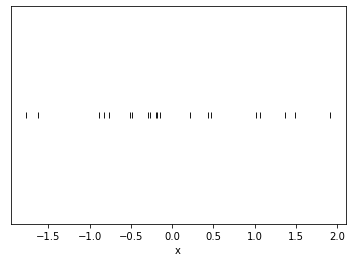

In [2]:
# make a synthetic dataset
np.random.seed(0)
x = torch.FloatTensor(np.random.randn(20))
x -= x.mean()
x /= x.std()

plt.plot(x, np.ones(*x.shape), 'k|', alpha=0.9);
plt.yticks([]);
plt.xlabel('x');

In [3]:
def log_joint(x, mean, precision):
    """ Define p(x | mu, tau)p(mu)p(tau) """
    return (dist.Normal(mean, 1.0/precision.sqrt()).log_prob(x[:, None]).sum(0) + 
            dist.Normal(0, 1).log_prob(mean) + 
            dist.Gamma(2.0, 2.0).log_prob(precision))

### Quick check: what does a Gamma prior look like?

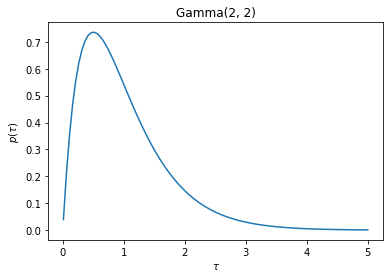

In [4]:
plt.plot(np.linspace(0.01, 5, 100), dist.Gamma(2.0, 2.0).log_prob(torch.linspace(0.01, 5, 100)).exp());
plt.xlabel("$\\tau$")
plt.ylabel("$p(\\tau)$");
plt.title("Gamma(2, 2)");

### Plot the unnormalized target density

We can do this because there are only two latent variables. For >2 it is hard to visualize!

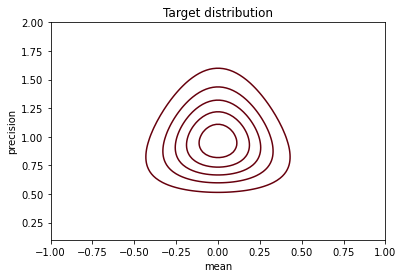

In [5]:
mu_vals, tau_vals = torch.meshgrid(torch.linspace(-1, 1, 100), 
                                     torch.linspace(0.1, 2, 100),
                                     indexing='ij')

lp = log_joint(x, mu_vals.reshape(-1), tau_vals.reshape(-1)).reshape(mu_vals.shape)

plt.contour(mu_vals, tau_vals, lp.exp(), cmap='Reds', vmin=-1, vmax=0, levels=5);

plt.title("Target distribution")
plt.xlabel("mean")
plt.ylabel("precision");

In [6]:
def q_dist(variational_params):
    """ Define q(mu)q(tau) """
    m, log_s, log_a, log_b = variational_params
    return dist.Normal(m, log_s.exp()), dist.Gamma(log_a.exp(), log_b.exp())

def q_sample(variational_params, N_samples):
    """ Sample mu, tau from q(mu)q(tau) 
        and return log probability of the sample """
    q_mu, q_tau = q_dist(variational_params)
    mu = q_mu.rsample((N_samples,))
    tau = q_tau.rsample((N_samples,))
    return mu, tau, q_mu.log_prob(mu) + q_tau.log_prob(tau)

def q_log_prob(mu, tau, variational_params):
    """ Compute log q(mu) + log q(tau) """
    q_mu, q_tau = q_dist(variational_params)
    return q_mu.log_prob(mu) + q_tau.log_prob(tau)

In [7]:
params = torch.ones(4).requires_grad_(True)
opt = torch.optim.SGD((params,), lr=0.01)

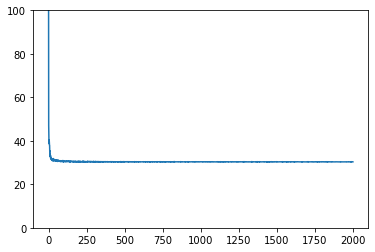

In [8]:
losses = []

for _ in range(2000):
    opt.zero_grad()
    mu, tau, lq = q_sample(params, 50)
    loss = -(log_joint(x, mu, tau) - lq).mean()
    loss.backward()
    opt.step()
    losses.append(loss.item())
    
plt.plot(losses);
plt.ylim(0, 100);

## Compare the learned approximation to the true posterior

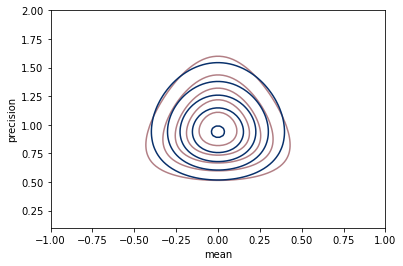

In [9]:
lq = q_log_prob(mu_vals.reshape(-1), tau_vals.reshape(-1), params.detach()).reshape(mu_vals.shape)

plt.contour(mu_vals, tau_vals, lp.exp(), cmap='Reds', vmin=-1, vmax=0, alpha=0.5, levels=5);
plt.contour(mu_vals, tau_vals, lq.exp(), cmap="Blues", vmin=-1, vmax=0, levels=5);

plt.xlabel("mean")
plt.ylabel("precision");